# Fit Data By Pictures: Show Effect of Varying Nucleation Time on Agreement with Collapsed Data Fit by JAK

In [1]:
import sys
sys.path.append('src/')
sys.path.append('../libs/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import polyco2
import bubbleflow
import analytics as an
import diffn
import bubble
import flow
import plot.bubble as pltb
import plot.genl as pltg
import plot.diffn as pltd

# CONVERSIONS
from conversions import *
# CONSTANTS
from constants import *

from importlib import reload
reload(bubbleflow)

# viscosity of inner and outer streams [Pa.s]
eta_i = 0.01 # see 20210207_sd301_co2_88bar_flow_props.ipynb for estimation
eta_o = 4.815
l_tube_o = 0.34 # length of tube for outer stream [m]
r_tube_o = 472E-6 # internal radius of tube for outer stream, approx [m]
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
Q_o = 335*uLmin_2_m3s # outer stream flow rate, input to ISCO 260 D [uL/min]
# inner stream flow rate [uL/min]
Q_i = 100*uLmin_2_m3s
# saturation pressure [Pa] -- might be lower due to depressurization events
# from February 6, 2021 (see p. 134 of lab notebook #0013)
p_s = 88E5
# measured values 
v = 1.82 # center stream velocity [m/s] -- measured
d = 0.079 # distance down observation capillary [m]
R_i = 22.4E-6 # [m] estimated with 20210207_sd301_co2_88bar_flow_props.ipynb
# diffusion model parameters 
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration
# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = 'input/1k3f_22c.csv'
# equation of state data
eos_co2_file = 'input/eos_co2_22-0C.csv'
# pressure in ISCO 260 D -- see p. 135 entry 2.1 of lab notebook #0013
p_260d = 1991*psi_2_Pa

# bubble growth model parameters
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]
# 3E-9 # initial bubble radius, estimated around prediction in slide 13 of 20200305_aps_march_meeting [m]

# frame rate [fps]
fps = 15000

# jak_bubble_growth_collapse.pptx
R_bubbles = np.array([5.06, 7.7, 10.12, 12.68, 14.82, 16.74])*0.5E-6
R_bubble = R_bubbles[0]


t_bubble = d / v # time bubble had traveled down channel [s]

# additional bubbles
f_bubbles = [i for i in range(0, len(R_bubbles))]
t_bubbles = np.asarray([t_bubble + f/fps for f in f_bubbles])

## Flow Parameters

In [2]:
# estimates pressure drop down observation capillary from ISCO 260 D [Pa]
p_in = p_260d - flow.p_pois(eta_o, l_tube_o, r_tube_o, Q_o)

# collects relevant parameters
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

print(p_in)

13262068.99311107


In [3]:
reload(diffn)
reload(bubble)
reload(bubbleflow)
reload(an)


def plot_pred_ep_fixed_D(L, eps_params, D):
    dt, p_s, R_nuc, _, p_in, v, polyol_data_file, eos_co2_file = eps_params
    eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

    # fits results to bubble growth model
    growth_fn = bubble.grow
    # arguments for bubble growth model
    dict_args = {'D' : D}
    i_t = 0 # index of t_bub in output of growth_fn
    i_R = 8 # index of R in output of growth_fn
    sigma_R = 0.02 # tolerance of error in radius


    ### TOLMAN LENGTH IS ESSENTIAL!!!
    i_t_nuc = 0

    # increases maximum iterations
    max_iter = 25

    # bounds on nucleation time
    t_nuc_lo = 0.043 # [s]
    t_nuc_hi = 0.0434 # [s]

    # opens figure to show results of different guesses for bubble nucleation time
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # uses modified shooting method to estimate the nucleation time
    t_nuc, output = an.fit_growth_to_pt(t_bubble, R_bubbles[0], t_nuc_lo, t_nuc_hi, growth_fn, list(eps_params),
                         i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)

    # unpacks output
    t, m, D, p, p_bub, if_tension, c_s, c_bulk, R, rho_co2 = output
    # prints pressure in stream upon nucleation of bubble
    print('p [Pa]', p[0])
    # groups results for plotting
    props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)

    # log time axis
    x_lim = [0.00000005, 25]
    y_lim = [0.001, 300]
    x_log = True
    ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='')
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t, props_list_fit[0]),
                          non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_bulk)
    pltg.legend(ax)

    # linear time axis
    x_lim = [0.0, 5]
    y_lim = [1, 50]
    x_log = False
    ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='')
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_s[0])

    pltg.legend(ax)

    return t, t_nuc, props_list_fit, t_bubbles, R_bubbles, R_i, R_o, v, c_bulk

t_nuc = 41.700 ms and error in R is 5.1032.
t_nuc = 42.550 ms and error in R is 3.5222.
t_nuc = 42.975 ms and error in R is 2.2670.
t_nuc = 43.188 ms and error in R is 1.3559.
t_nuc = 43.294 ms and error in R is 0.7107.
t_nuc = 43.347 ms and error in R is 0.2580.
t_nuc = 43.373 ms and error in R is 0.0863.
t_nuc = 43.360 ms and error in R is 0.0908.
t_nuc = 43.367 ms and error in R is 0.0098.
t_nuc = 43.370 ms and error in R is 0.0230.
t_nuc = 43.368 ms and error in R is 0.0101.
t_nuc = 43.369 ms and error in R is 0.0231.
t_nuc = 43.369 ms and error in R is 0.0231.
t_nuc = 43.369 ms and error in R is 0.0101.
t_nuc = 43.369 ms and error in R is 0.0231.
t_nuc = 43.369 ms and error in R is 0.0232.
t_nuc = 43.369 ms and error in R is 0.0232.
t_nuc = 43.369 ms and error in R is 0.0101.
t_nuc = 43.369 ms and error in R is 0.0101.
t_nuc = 43.369 ms and error in R is 0.0101.
t_nuc = 43.369 ms and error in R is 0.0232.
t_nuc = 43.369 ms and error in R is 0.0232.
t_nuc = 43.369 ms and error in R

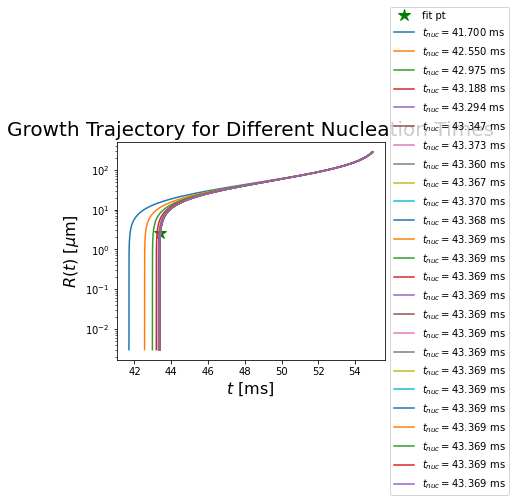

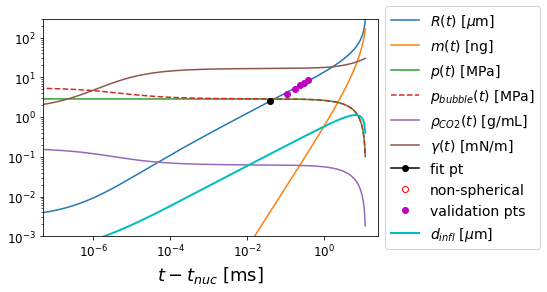

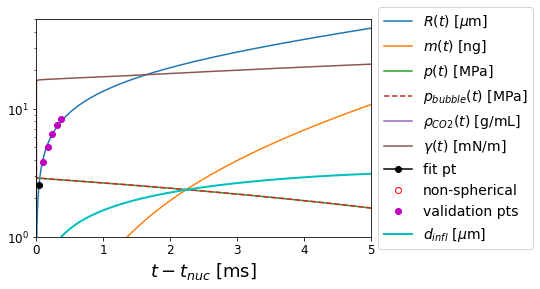

In [12]:
D = 4E-9 # [m^2/s]
L = 0.1 # [m]
t, t_nuc, props_list_fit, t_bubbles, R_bubbles, R_i, R_o, v, c_bulk = plot_pred_ep_fixed_D(L, eps_params, D)

Model prediction at fit point is R = 2.471414 um.


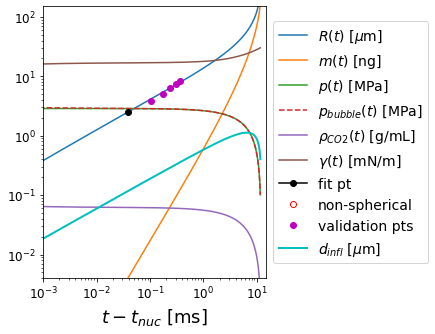

In [13]:
reload(pltb)
# log time axis
x_lim = [1E-3, 1.5E1]
y_lim = [0.004, 150]
x_log = True
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(111)
ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t, props_list_fit[0]),
                  non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


## Diffusivity Models

In [116]:
# global constants for diffusion model
filepath_D_c='../g-adsa_results/D_c_power_law.csv'
df_D = pd.read_csv(filepath_D_c)
D0, A_p, k_p = df_D['p']

def D_p(c):
    """
    Power-law fit for D(c) fitted to *pressurization* data of 1k3f @ 30c
    (see 20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return D0 + A_p * c**k_p

def D_p2(c):
    """
    Power-law fit for D(c) fitted to *pressurization* data of 1k3f @ 30c
    (see 20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return 2*(D0 + A_p * c**k_p)


# depressurization data-based model of diffusivity
D0, A_dp, k_dp = df_D['dp']

def D_dp(c):
    """
    Power-law fit for D(c) fitted to *depressurization* data of 1k3f @ 30c
    (see 20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return D0 + A_dp * c**k_dp

## Plot Bubble Growth For Different Nucleation Times For Comparison to Data

0% complete, t = 0.000 ms.
10% complete, t = 5.500 ms.
20% complete, t = 10.991 ms.
30% complete, t = 16.491 ms.
40% complete, t = 21.982 ms.
50% complete, t = 27.473 ms.
60% complete, t = 32.974 ms.
70% complete, t = 38.465 ms.
regridding
80% complete, t = 43.962 ms.
halving grid
halving grid
remeshed
90% complete, t = 49.482 ms.
0% complete, t = 0.000 ms.
10% complete, t = 5.500 ms.
20% complete, t = 10.991 ms.
30% complete, t = 16.491 ms.
40% complete, t = 21.982 ms.
50% complete, t = 27.473 ms.
60% complete, t = 32.974 ms.
70% complete, t = 38.465 ms.
regridding
80% complete, t = 43.956 ms.
90% complete, t = 49.456 ms.
halving grid
halving grid
remeshed
0% complete, t = 0.000 ms.
10% complete, t = 5.500 ms.
20% complete, t = 10.991 ms.
30% complete, t = 16.491 ms.
40% complete, t = 21.982 ms.
50% complete, t = 27.473 ms.
60% complete, t = 32.974 ms.
70% complete, t = 38.465 ms.
regridding
80% complete, t = 43.962 ms.
90% complete, t = 49.453 ms.


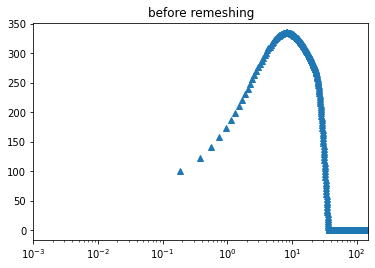

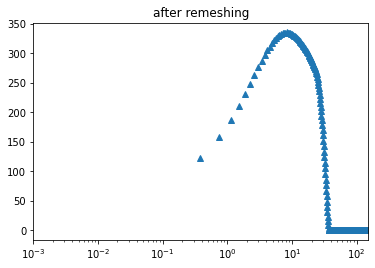

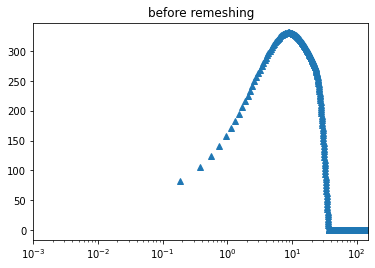

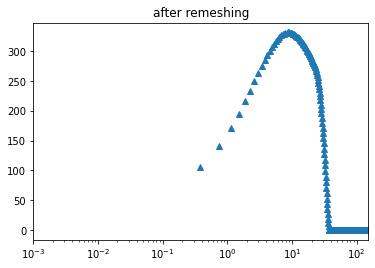

In [131]:
reload(diffn)
reload(bubbleflow)

# fits results to bubble growth model
growth_fn = bubbleflow.sheath_incompressible
D_fn = D_p
# indices of outputs of growth function
i_t = 2
i_R = 10
eta_ratio = 300/4815

# groups arguments for growth model
# grid points
N = 800
D_max = D_fn(500) # [m^2/s]
R_max = R_o
dt_sheath = 0.5*(R_max/N)**2/D_max
args = [eps_params, R_max, N, R_i, dt_sheath]
dict_args = {'remesh_fn' : diffn.manage_grid_halving, 
             'remesh_params' : {'pts_per_grad' : 5, 'interp_kind' : 'quadratic'}, 'D_fn' : D_fn,
             'remesh_freq' : 100, 'alpha' : 0.3, 'eta_ratio' : eta_ratio} #, 't_f' : t_bubbles[-1]}

# bounds on nucleation time
t_nuc_lo = 0.0424 # [s]
t_nuc_hi = 0.0434 # [s]
n_plots = 3

# lists of data for plotting
t_list = []
R_list = []
output_list = []

t_nuc_list = np.linspace(t_nuc_lo, t_nuc_hi, n_plots)

for t_nuc in t_nuc_list:
    output = growth_fn(t_nuc, *tuple(args), **dict_args)
    t_list += [output[i_t]]
    R_list += [output[i_R]]
    output_list += [output]

## Plot Results

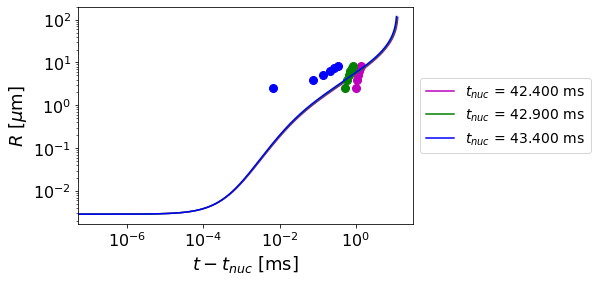

In [132]:
# creates figure for plotting
fig = plt.figure()
ax = fig.add_subplot(111)


colors = ['m', 'g', 'b', 'k', 'r']

# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
#           'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for t_nuc, t, R, color in zip(t_nuc_list, t_list, R_list, colors):
    # plots on shared figure
    ax.plot((np.asarray(t)-t_nuc)*s_2_ms, np.array(R)*m_2_um, label=r'$t_{nuc}$ = ' + '{0:.3f} ms'.format(t_nuc*s_2_ms),
               color=color)
    # plots data shifted to match the given nucleation time
    ax.plot((t_bubbles-t_nuc)*s_2_ms, np.array(R_bubbles)*m_2_um, marker='o', markersize=8, lw=0, color=color)

# plots measured bubble sizes on the same axes
# pltb.measured(ax, t_bubble, t_bubble, t_bubbles, R_bubble, R_bubbles[1:])

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim([0.1, 20])
# ax.set_xlim([1E-3, 5])
ax.set_xlabel(r'$t-t_{nuc}$ [ms]', fontsize=18)
ax.set_ylabel(r'$R$ [$\mu$m]', fontsize=18)
ax.tick_params(labelsize=16)
pltg.legend(ax)

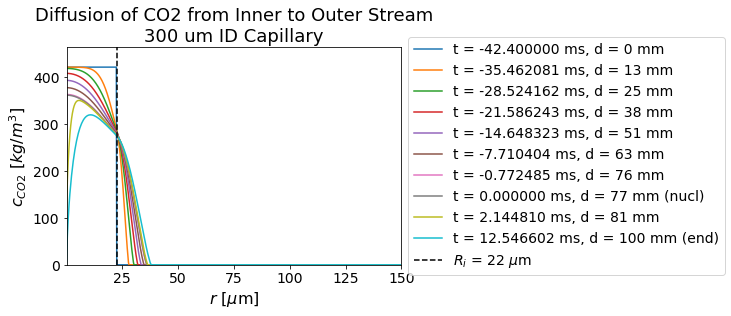

In [133]:
# plot concentration profile
n_plot = 8

output = output_list[0]

t_flow, c, t_bub, m, D, p, p_bub, if_tension, c_bub, c_bulk, R, \
            rho_co2, v, r_arr_data = output

ax = pltd.sheath_remesh(np.asarray(t_flow), r_arr_data, c, R_i, R_o, v, c_bulk, n_plot, t_nuc=t_nuc_list[0])
# ax.set_xscale('log')
ax.set_xlim([1E-3, 150])
pltg.legend(ax)


### Remove Diffusion into Outer Sheath

Because I haven't succeeded in making a convergent computation using the sheath flow model with reduced outer stream viscosity, I will try modeling the stream without loss to the outer stream.

In [109]:
reload(bubbleflow)

# fits results to bubble growth model
growth_fn = bubbleflow.num_vary_D
D_fn = D_p2
# indices of outputs of growth function
i_t = 2
i_R = 10

# groups arguments for growth model
# grid points
N = 800
D_max = D_fn(500) # [m^2/s]
R_max = R_o
dt_sheath = 0.5*(R_max/N)**2/D_max
args = [eps_params, R_max, N, R_i, dt_sheath]
dict_args = {'remesh_fn' : diffn.manage_grid_halving, 
             'remesh_params' : {'pts_per_grad' : 5, 'interp_kind' : 'quadratic'}, 'D_fn' : D_fn,
             'remesh_freq' : 100, 'alpha' : 0.3} #, 't_f' : t_bubbles[-1]}

# bounds on nucleation time
t_nuc_lo = 0.0424 # [s]
t_nuc_hi = 0.0434 # [s]
n_plots = 3

# lists of data for plotting
t_list = []
R_list = []

t_nuc_list = np.linspace(t_nuc_lo, t_nuc_hi, n_plots)

for t_nuc in t_nuc_list:
    output = growth_fn(t_nuc, *tuple(args), **dict_args)
    t_list += [output[i_t]]
    R_list += [output[i_R]]

halving grid
halving grid
remeshed
t 0.0016599584590567332 dt 4.459386782770089e-06 dt_max 1.8550585914140607e-05
halving grid
halving grid
remeshed
t 0.001754992738291522 dt 3.7681818314407257e-06 dt_max 1.8550585914140607e-05
halving grid
halving grid
remeshed
t 0.001754927256447443 dt 3.7681818314407257e-06 dt_max 1.8550585914140607e-05


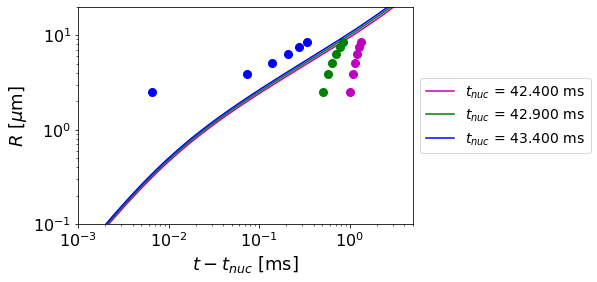

In [111]:
# creates figure for plotting
fig = plt.figure()
ax = fig.add_subplot(111)

colors = ['m', 'g', 'b', 'k', 'r']

for t_nuc, t, R, color in zip(t_nuc_list, t_list, R_list, colors):
    # plots on shared figure
    ax.plot((np.asarray(t)-t_nuc)*s_2_ms, np.array(R)*m_2_um, label=r'$t_{nuc}$ = ' + '{0:.3f} ms'.format(t_nuc*s_2_ms),
               color=color)
    # plots data shifted to match the given nucleation time
    ax.plot((t_bubbles-t_nuc)*s_2_ms, np.array(R_bubbles)*m_2_um, marker='o', markersize=8, lw=0, color=color)

# plots measured bubble sizes on the same axes
# pltb.measured(ax, t_bubble, t_bubble, t_bubbles, R_bubble, R_bubbles[1:])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.1, 20])
ax.set_xlim([1E-3, 5])
ax.set_xlabel(r'$t-t_{nuc}$ [ms]', fontsize=18)
ax.set_ylabel(r'$R$ [$\mu$m]', fontsize=18)
ax.tick_params(labelsize=16)
pltg.legend(ax)